# Identificador de cabelos

Tarefa 2

# Autor
Nome: Samuel Nogueira Bacelar

Matrícula: 180130722

Github: [SamuelNoB](https://github.com/SamuelNoB)

# Objetivo

O objetivo deste artigo é o de criar um modelo capaz de reconhecer e diferenciar os principais tipos de cabelos existentes em ambos os sexos. Os principais tipos de cabelos são: Crespo, Ondulado, Liso, Cacheado e sem cabelo.

Além disso realizar o deploy no Huggin face

## Passo 1: Baixar imagens de diferentes tipos de cabelos

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Iniciamos produrando por imagens de pessoas de cabelo crespo

In [2]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('coily hair male photos', max_images=3)
urls[2]


Searching for 'coily hair male photos'


'https://ath2.unileverservices.com/wp-content/uploads/sites/3/2016/05/curly-natural-hair-medium-black-mens.jpg'

Então baixamos uma imagem poder visualiza-la

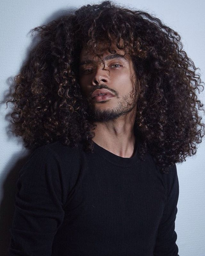

In [3]:
from fastdownload import download_url
dest = 'curly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Então procuramos pelos quatro tipos principais de cabelos, em ambos os sexos e com plano de fundo fora e dentro de um ambiente interno.

In [4]:
searches = 'straight','curly', 'wavy', 'coily', 'bald'
path = Path('hair_types')
from time import sleep

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} hair photo'))
#     sleep(10)  # Pause between searches to avoid over-loading server
#     download_images(dest, urls=search_images(f'{o} hair male photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} hair outdoor photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} hair male outdoor photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} hair bearded photo'))
#     resize_images(path/o, max_size=600, dest=path/o)

## Passo 2: Treinando o modelo

Primeiro é necessário remover fotos que tiveram erros no momento do download de modo a não impactar o treinamento do modelo

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para treinar um modelo, precisaremos de `DataLoaders`, que é um objeto que contém um **conjunto de treinamento** (as imagens usadas para criar um modelo) e um **conjunto de validação** (as imagens usadas para verificar a precisão de um modelo - não usado durante o treinamento). No `fastai`, podemos criar isso facilmente usando um `DataBlock` e visualizar imagens de amostra a partir dele:

In [6]:
hairs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)


Aqui está o que cada um dos parâmetros `DataBlock` significa:

    blocks=(ImageBlock, CategoryBlock),

As entradas para o nosso modelo são imagens e as saídas são categorias (neste caso, "pássaro" ou "floresta").

    get_items=get_image_files,

Para encontrar todas as entradas para o nosso modelo, execute a função `get_image_files` (que retorna uma lista de todos os arquivos de imagem em um caminho).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Divida os dados em conjuntos de treinamento e validação aleatoriamente, usando 20% dos dados para o conjunto de validação.

    get_y=parent_label,

Os rótulos (valores `y`) são o nome do `pai` de cada arquivo (ou seja, o nome da pasta em que estão, que será *pássaro* ou *floresta*).

    item_tfms=[Resize(192, method='squish')]

Antes do treinamento, redimensione cada imagem para 192x192 pixels "espremendo-a" (em vez de cortá-la).

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o `resnet50`. Você pode treiná-lo em poucos minutos, mesmo em uma CPU! (Em uma GPU, geralmente leva menos de 10 segundos...)

O `fastai` vem com um método útil `fine_tune()` que automaticamente usa as melhores práticas para ajustar um modelo pré-treinado, então usaremos isso.

### configurações adicionais
As duas células forçam a execução do garbage collector e do cache e tambem faz com que o output do resultado dos modelos treinados sejam exibidos corretamente.

In [7]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()


0

In [8]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

### Data augmentation
A fim de melhorar o desempenho do treinamento, uma estratégia de transformação das imagens será usada.

O **Data augmentation** é a criação de variações aleatórias dos dados de entrada, de tal forma que elas aparentem ser diferentes, apesar de serem a mesma imagem.

Algumas informações sobre métodos e funções usadas: 
- *aug_transforms()* é um padrão de augmentations indicado na aula e com boa performance para imagens de fotos naturais.
- *batch_tfms* é um método do fastai que indica o uso dessas transformações.
- *RandomResizedCrop*: Recorta e redimenciona de maneira aleátoria a imagem

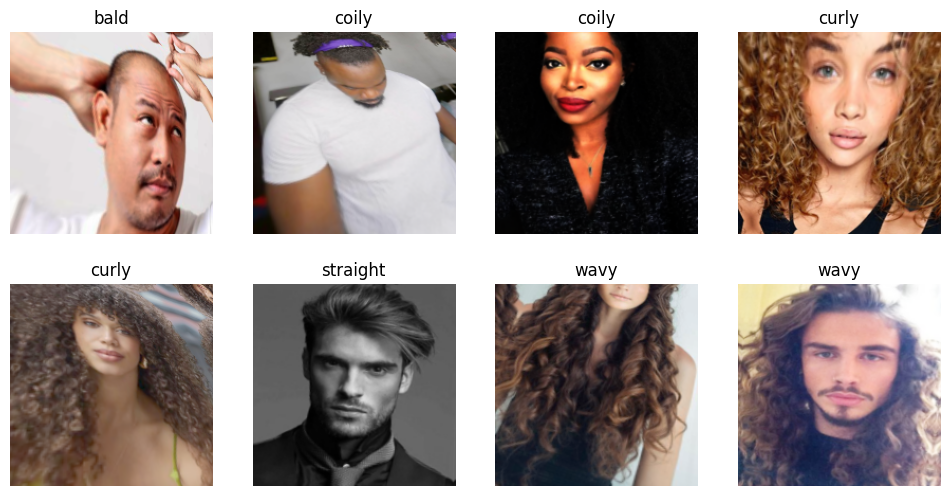

In [9]:
hairs = hairs.new(
    item_tfms=RandomResizedCrop(192, min_scale=0.5), 
    batch_tfms=aug_transforms(mult=2))
hairs_dls = hairs.dataloaders(path, bs=32, pin_memory=False)
hairs_dls.train.show_batch(max_n=8, nrows=2, unique=False)

### Treinando
Aqui treinamos nosso modelo com um total de 7 iterações.

In [10]:
learn = vision_learner(hairs_dls, resnet50, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,0.981135,0.521613,0.141509,00:07
1,0.815396,0.663319,0.169811,00:07
2,0.678006,0.707464,0.188679,00:07
3,0.563768,0.612708,0.113208,00:07
4,0.504607,0.584915,0.103774,00:07
5,0.462199,0.572135,0.103774,00:07
6,0.387126,0.559764,0.113208,00:07


Como visto acima obtemos uma taxa de erros de 11.32%.

## Limpando o modelo
Para diminuir as perdas e reduzir a taxa de erro podemos limpar o modelo. Primeiro geraremos uma matriz de confusão para ver quais erros estão sendo cometidos pelo modelo, quais os tipos de cabelo que ele mais confunde.


### Matriz de confusão


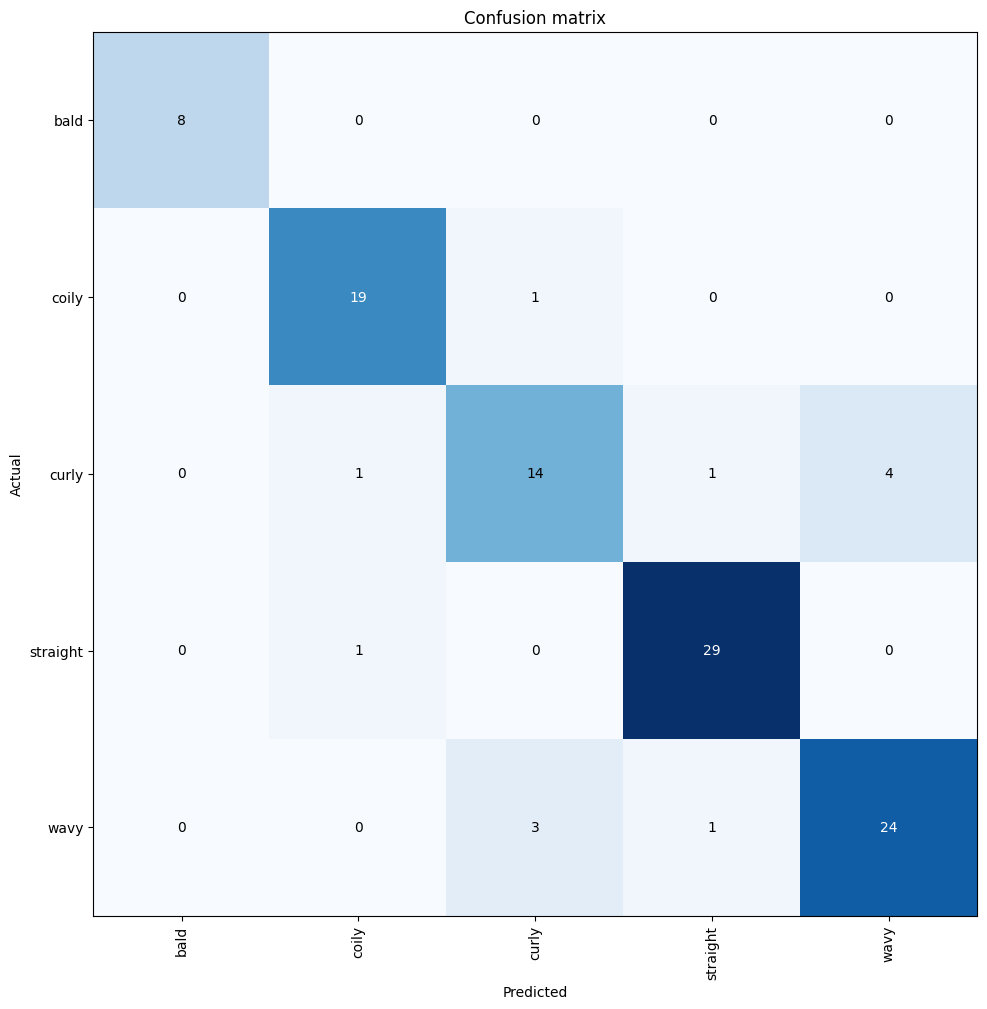

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

As colunas da matriz representam as imagens de tipos de cabelo que o modelo prediz, e as linhas representam o conjunto de imagens de tipos de cabelo utilizadas no treinamento.

A diagonal principal representa os acertos (predição condiz com a label). Enquanto as outras intercessões mostram os erros cometidos, sendo quanto maior o número de uma celula mais vezes ocorreu a confusão.

Para entender melhor o que os erros mostram (um erro do modelo ou das imagens) pode ser útil ordenar as imagens pela perda (loss).

**Quanto mais incorreto é o modelo maior a perda (loss)**, especialmente quando o erro ocorre com alta confiança. A perda (loss) também é alta quando a predição está correta porém com pouca confiança na resposta.

Algumas das imagens foram confusões justas devido a semelhança, como é o caso de cabelos **ondulados** e **cacheados** e também com **cacheados** e **crespos**.

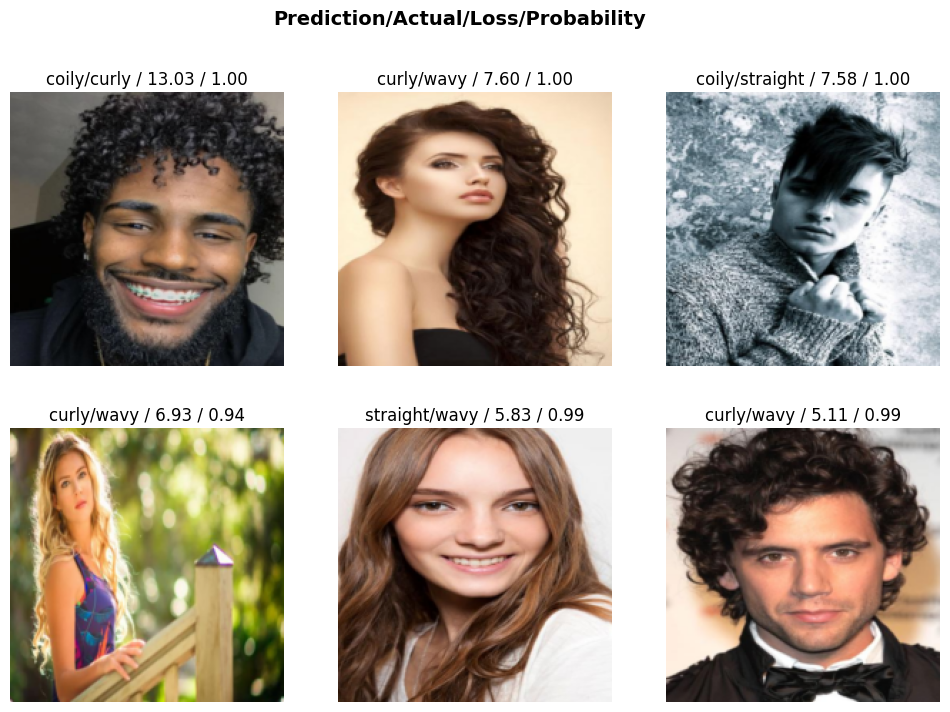

In [12]:
interp.plot_top_losses(6, figsize=(12,8))

Após esse processo o modelo auxiliou a identificar onde o dado pode ser mais problemático de maneira rápida.

Para melhorar o conjunto de dados é preciso fazer uma **limpeza dos dados**. O fastai possui uma GUI para isso chamada *ImageClassifierCleaner*, essa GUI será usada para selecionar imagens para remoção ou realocar.

In [13]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Para realizar as remoções e realocamento das imagens indicadas basta utilizar esses 2 loops:

In [14]:

for idx in cleaner.delete(): 
    print("deletando: ", cleaner.fns[idx])
    cleaner.fns[idx].unlink()

for idx,cat in cleaner.change():
    print("movendo: ", cleaner.fns[idx], '\nPara: ', path/cat)
    shutil.move(str(cleaner.fns[idx]), path/cat)

### Treinando novamente
Uma vez que ocorre a limpeza dos dados, o modelo pode ser **re-treinado** a fim de alcançar melhores resultados.
ps: Remova os comentários para rodar este trecho após realizar a limpeza de dados

In [16]:
# hairs = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_image_files, 
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),
#     get_y=parent_label,
#     item_tfms=[Resize(192, method='squish')]
# ).dataloaders(path, bs=32, pin_memory=False)


In [17]:

# learn = vision_learner(hairs, resnet50, metrics=error_rate)
# learn.fine_tune(7)

## Passo 3: Testando o modelo

Com o modelo treinado, basta executar a última tela e será retornado um prompt informando qual é o tipo de cabelo da pessoa na foto, uma probabilidade de ser o tipo de cabelo predito e a imagem inserida.

In [18]:
translator = {
    "coily": "Crespo",
    "straight": "Liso",
    "curly": "Cacheado",
    "wavy": "Ondulado",
    "bald": "Careca"
}

É um cabelo Crespo.
Probabilidade de ser do tipo Crespo: 58.15%


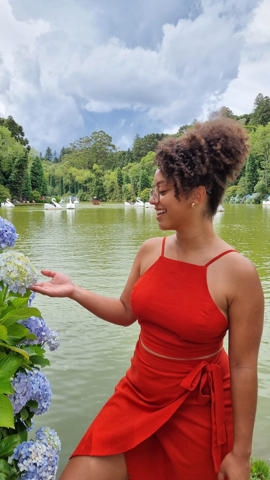

In [19]:
prediction_photo='coily.jpg'

hair_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É um cabelo {translator[hair_type]}.")
print(f"Probabilidade de ser do tipo {translator[hair_type]}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

# Deploy

## Código de deploy
Foi realizado o deploy no hugging Face No seguinte link
```python
import gradio as gr
from fastai.vision.all import *

learn = load_learner('export.pkl')
labels = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Fruit Classifier"
examples = ['banana.jpg', 'jabuticaba.jpeg', 'laranja.jpg',  'maca.jpg', 'melancia.jpeg']

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.inputs.Image(shape=(512, 512)),
    outputs=gr.outputs.Label(num_top_classes=3),
    title=title,
    examples=examples,
    )
iface.launch(inline=False)
```

In [20]:
learn.path = Path('.')
learn.export("export")

# Conclusão
Como existem diversos "meio termos" de cabelos, classificar um tipo de cabelo em uma das quatro categorias propostas pode acabar gerando uma falta de acurácia por parte do modelo. Realizar a identificação de um cabelo liso para um não liso é fácil, entretanto quando entra no espéctro dos cabelos "ondulados" fica mais dificil distinguir um cabelo do outro. Isso justifica o porque da taxa de erros ser de 11%

Para aprimorar a acurácia do modelo foi necessário separar manualmente os dados usados para o treinamento. Nos primeiros treinamentos a taxa de erros chegava a ser maior que 27% e a separação manual melhorou a acurácia do modelo. Com isso, verifica-se que, a qualidade da classificação dos dados de treinamento impacta diretamente na assertividade do modelo.